In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import numpy as np

In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from os import listdir, makedirs
from os.path import join, exists, expanduser
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import log_loss, accuracy_score
from keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras import Model

Using TensorFlow backend.


In [4]:
#Since there are too many images and image classes, we'll consider only the top 16 classes
INPUT_SIZE = 300
NUM_CLASSES = 16
SEED = 1987
data_dir = os.getcwd()
labels = pd.read_csv(join(data_dir, 'labels.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))))

10222 10222
10357


In [21]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels['breed'].rank(ascending=0,method='dense')
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
np.random.seed(seed=SEED)
rnd = np.random.random(len(labels))
# train_idx = rnd < 0.8
# valid_idx = rnd >= 0.8
y_train_val = labels_pivot[selected_breed_list].values
# y_train = y_train_val[train_idx]
# y_val = y_train_val[valid_idx]


In [15]:
def read_img(img_id, train_or_test, size):
    img = image.load_img(join(data_dir, train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.img_to_array(img)
    img = img/255.0
    return img

In [16]:
from tqdm import tqdm
from keras.preprocessing import image
x_train_val = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train_val[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train_val.shape, x_train_val.size))

1777it [00:08, 208.78it/s]

Train Images shape: (1777, 300, 300, 3) size: 479,790,000


In [38]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
x_train_val,y_train_val = shuffle(x_train_val,y_train_val)
x_train,x_val,y_train,y_val = train_test_split(x_train_val,y_train_val,test_size = 0.2)

In [39]:
# x_train = x_train_val[train_idx]
# x_val = x_train_val[valid_idx]
print((x_train.shape, x_val.shape, y_train.shape, y_val.shape))
pre_trained_model = InceptionV3(input_shape = (300,300,3),
                               include_top = False,
                               weights = 'imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False

((1421, 300, 300, 3), (356, 300, 300, 3), (1421, 16), (356, 16))


In [40]:
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 8, 8, 2048)


In [25]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.97):
      print("\nReached 97.0% accuracy so cancelling training!")
      self.model.stop_training = True

In [41]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(512,activation = 'relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(16,activation = 'softmax')(x)           

model = Model(pre_trained_model.input,x) 

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

In [42]:
callbacks = myCallback()
history = model.fit(x_train,y_train,batch_size = 32,epochs = 10,verbose = 1,validation_steps = 12, validation_data = (x_val,y_val))

Train on 1421 samples, validate on 356 samples
Epoch 1/10
1421/1421 [==============================] - 17s 12ms/sample - loss: 18.3092 - acc: 0.4947 - val_loss: 199.3919 - val_acc: 0.0590
Epoch 2/10
1421/1421 [==============================] - 12s 8ms/sample - loss: 0.5864 - acc: 0.8410 - val_loss: 285.2321 - val_acc: 0.0674
Epoch 3/10
1421/1421 [==============================] - 12s 8ms/sample - loss: 0.3250 - acc: 0.9078 - val_loss: 296.1580 - val_acc: 0.0758
Epoch 4/10
1421/1421 [==============================] - 12s 8ms/sample - loss: 0.2727 - acc: 0.9191 - val_loss: 553.3824 - val_acc: 0.0365
Epoch 5/10
1421/1421 [==============================] - 12s 8ms/sample - loss: 0.2826 - acc: 0.9240 - val_loss: 444.2322 - val_acc: 0.0815
Epoch 6/10
1421/1421 [==============================] - 12s 8ms/sample - loss: 0.2230 - acc: 0.9374 - val_loss: 351.6566 - val_acc: 0.0674
Epoch 7/10
1421/1421 [==============================] - 12s 8ms/sample - loss: 0.2144 - acc: 0.9388 - val_loss: 538.6

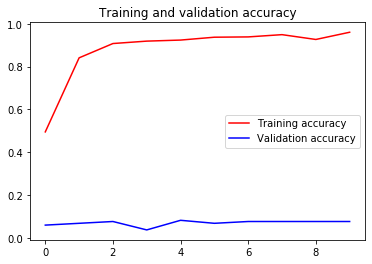

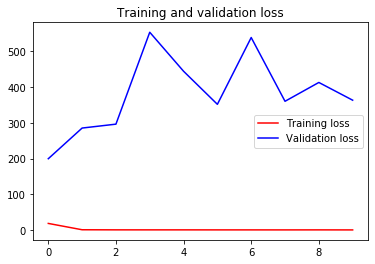

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'r',label = 'Training loss')
plt.plot(epochs, val_loss,'b',label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()